In [1]:
# import packages
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# load dataset
df = pd.read_csv("../data/biosensor_dataset_with_target.csv")

In [3]:
# Convert timestamp column
df["Timestamp"] = pd.to_datetime(df["Timestamp"], errors="coerce")

# Sort by time for safety
df = df.sort_values(["Athlete_ID", "Timestamp"])

In [4]:
def plot_signal_window_with_ticks(
    df: pd.DataFrame,
    athlete_id: str,
    event_label: str,
    window_before_s: float = 0.5,
    window_after_s: float = 0.5,
    event_index: int = 0,
    accel_cols = ("Acc_X", "Acc_Y", "Acc_Z"),
    gyro_cols  = ("Gyro_X", "Gyro_Y", "Gyro_Z"),
    heart_col: str = "Heart_Rate",
    show_all_xticks: bool = True,
):
    """
    Draws signal plots around a specific event and labels the vertical line with the event name.
    """

    # ensure datetime & sort
    work = df.copy()
    work["Timestamp"] = pd.to_datetime(work["Timestamp"], errors="coerce")
    subset = work[work["Athlete_ID"] == athlete_id].sort_values("Timestamp")

    # select event occurrence
    events = subset[subset["Event_Label"] == event_label]
    if events.empty or event_index >= len(events):
        return

    event_time = events.iloc[event_index]["Timestamp"]

    # window around event
    start = event_time - pd.Timedelta(seconds=window_before_s)
    end   = event_time + pd.Timedelta(seconds=window_after_s)
    win = subset[(subset["Timestamp"] >= start) & (subset["Timestamp"] <= end)].copy()
    if win.empty:
        return

    # columns to plot
    acc_cols  = [c for c in accel_cols if c in win.columns]
    gyr_cols  = [c for c in gyro_cols if c in win.columns]
    has_hr    = heart_col in win.columns

    nrows = (1 if acc_cols else 0) + (1 if gyr_cols else 0) + (1 if has_hr else 0)
    if nrows == 0:
        return

    fig, axes = plt.subplots(nrows, 1, figsize=(12, 2.6 * nrows), sharex=True)
    if nrows == 1:
        axes = [axes]

    r = 0
    def _plot_block(ycols, title, ylabel):
        nonlocal r
        ax = axes[r]
        for c in ycols:
            ax.plot(win["Timestamp"], win[c], label=c)
        ax.axvline(event_time, linestyle="--", c="r")
        ymax = ax.get_ylim()[1]
        ax.annotate(
            f"{event_label}\n",
            xy=(event_time, ymax),
            xytext=(4, -4),
            textcoords="offset points",
            va="top"
        )
        ax.set_title(title)
        ax.set_ylabel(ylabel)
        ax.legend(loc="best")
        r += 1

    if acc_cols:
        _plot_block(acc_cols, f"{athlete_id} • Accelerometer around {event_label}", "Accel")
    if gyr_cols:
        _plot_block(gyr_cols, f"{athlete_id} • Gyroscope around {event_label}", "Gyro")
    if has_hr:
        _plot_block([heart_col], f"{athlete_id} • Heart Rate around {event_label}", "bpm")

    if show_all_xticks:
        ticks = win["Timestamp"].values
        ticklbls = win["Timestamp"].dt.strftime("%H:%M:%S.%f").str[:-3]
        for ax in axes:
            ax.set_xticks(ticks)
            ax.set_xticklabels(ticklbls, rotation=45, ha="right")

    axes[-1].set_xlabel("Timestamp")
    plt.tight_layout()
    plt.show()

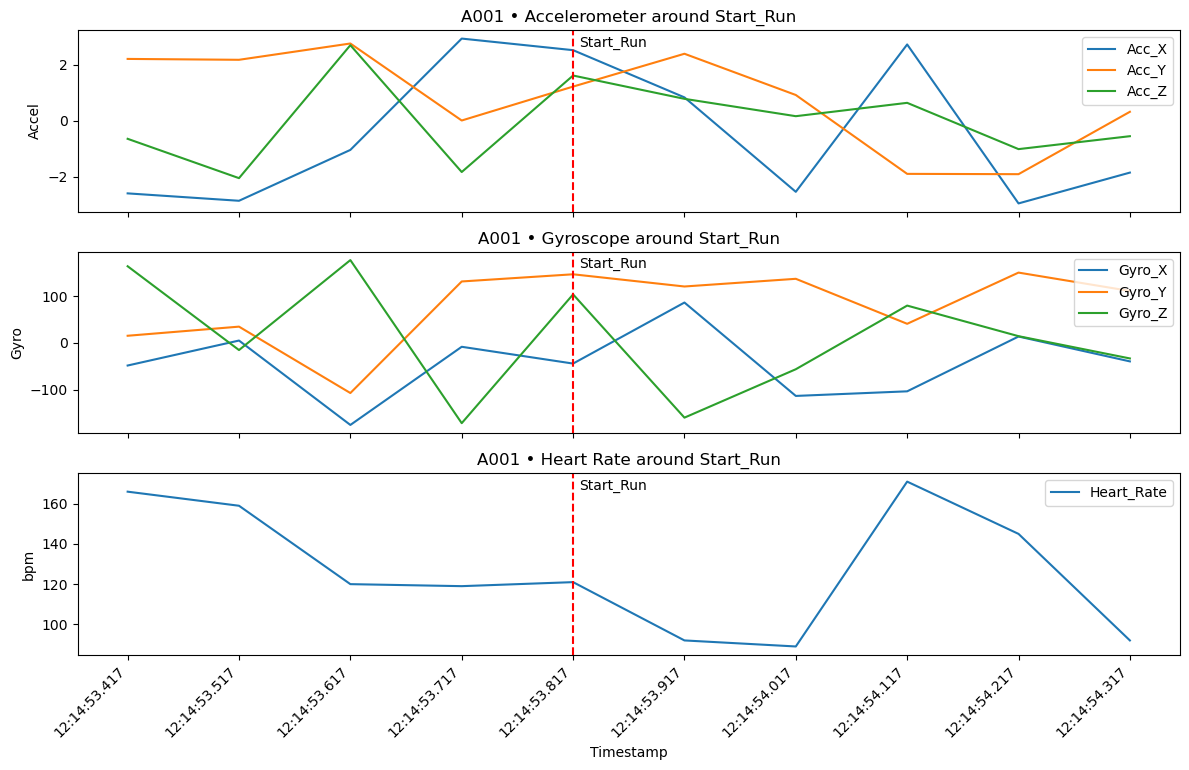

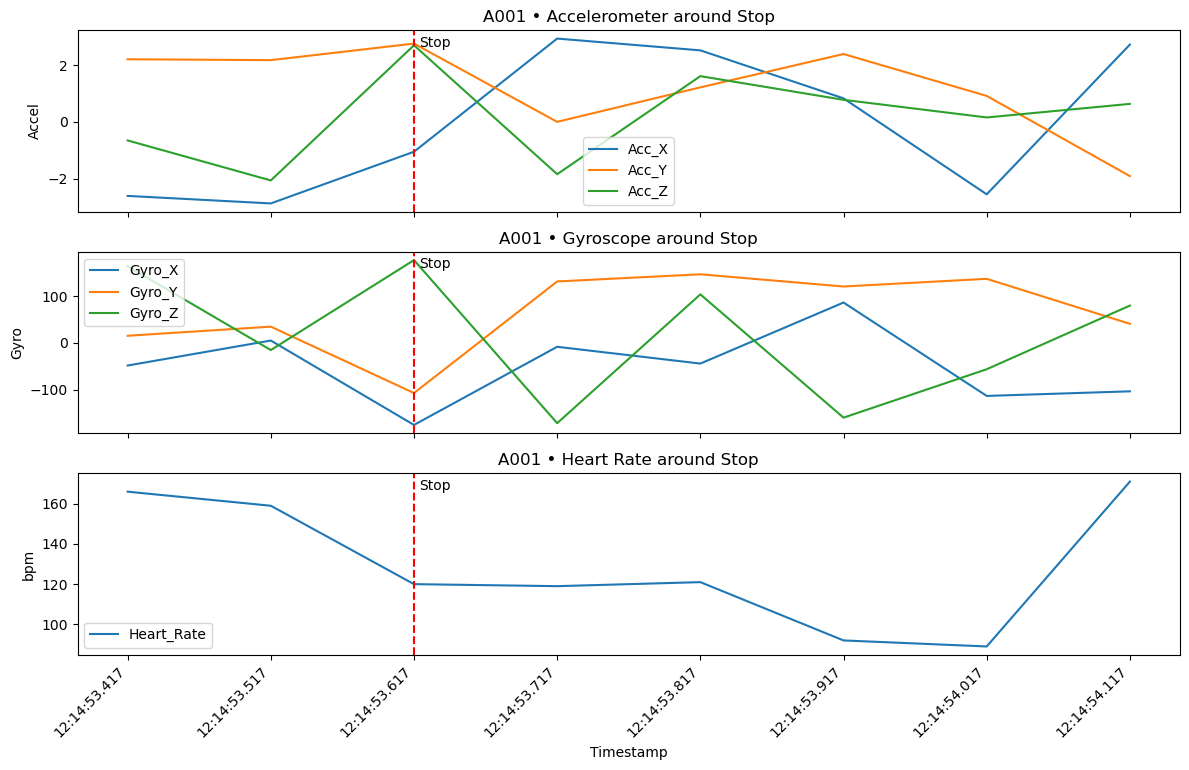

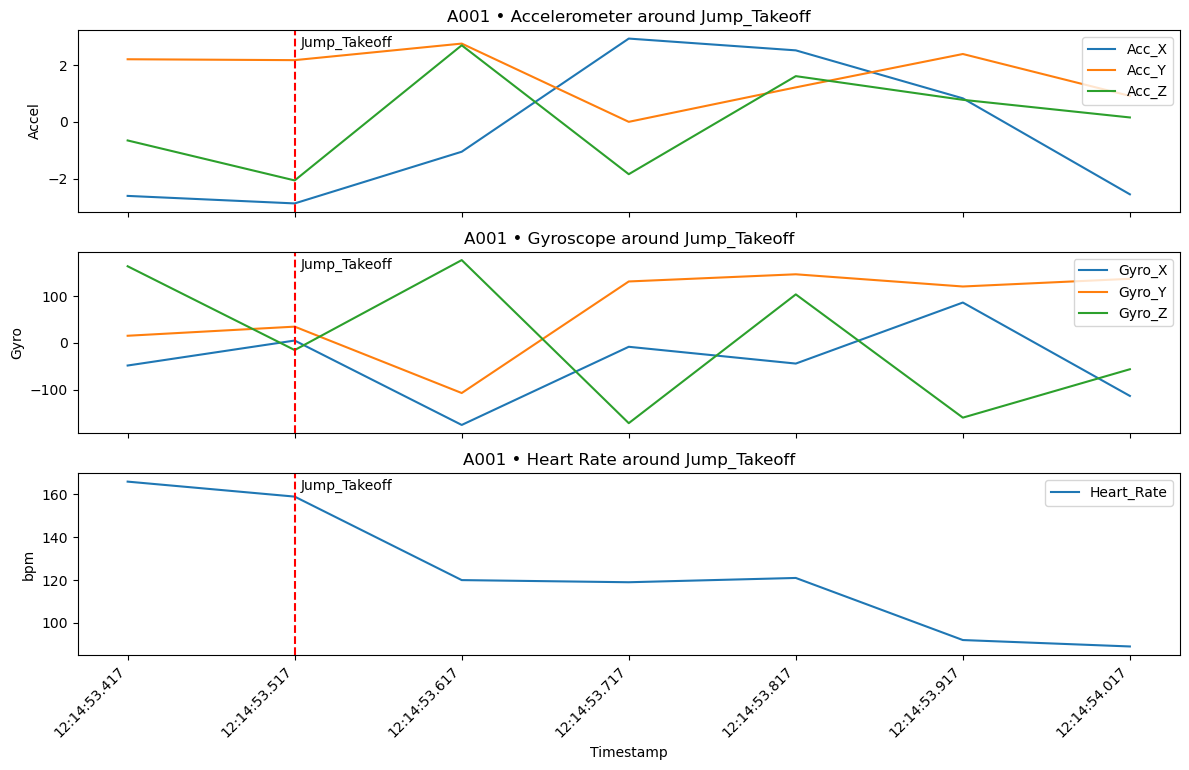

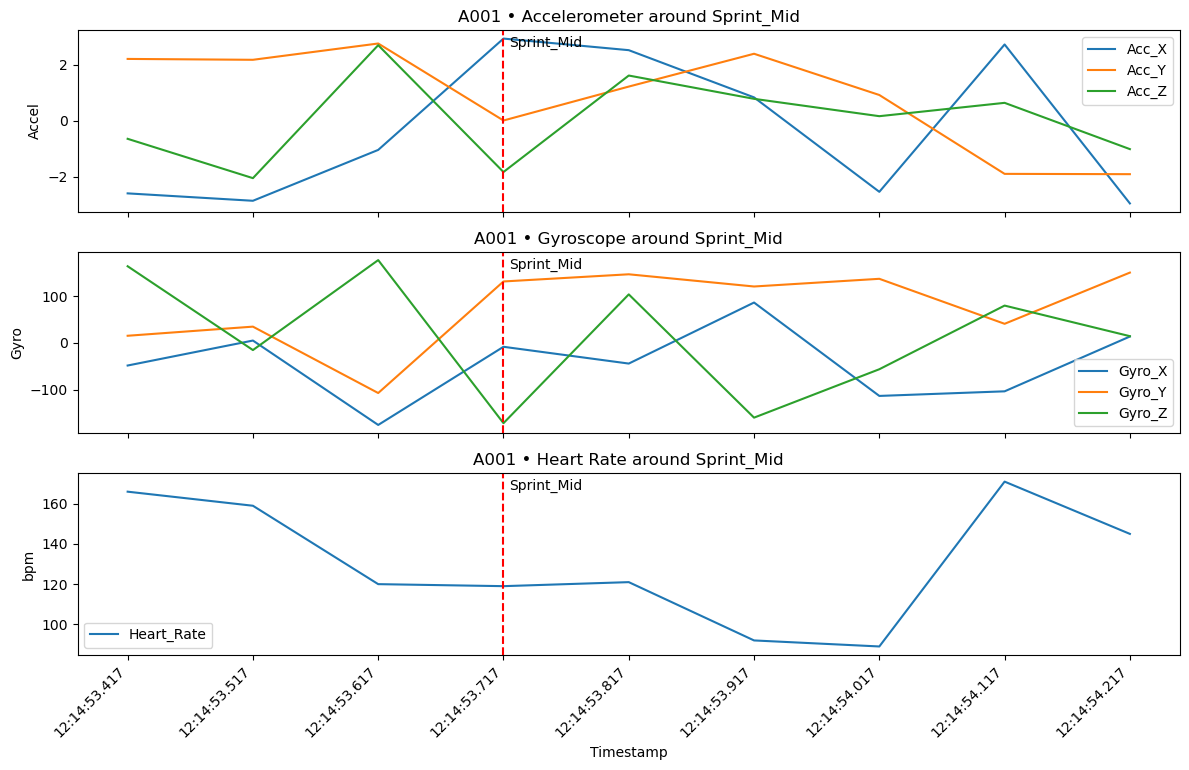

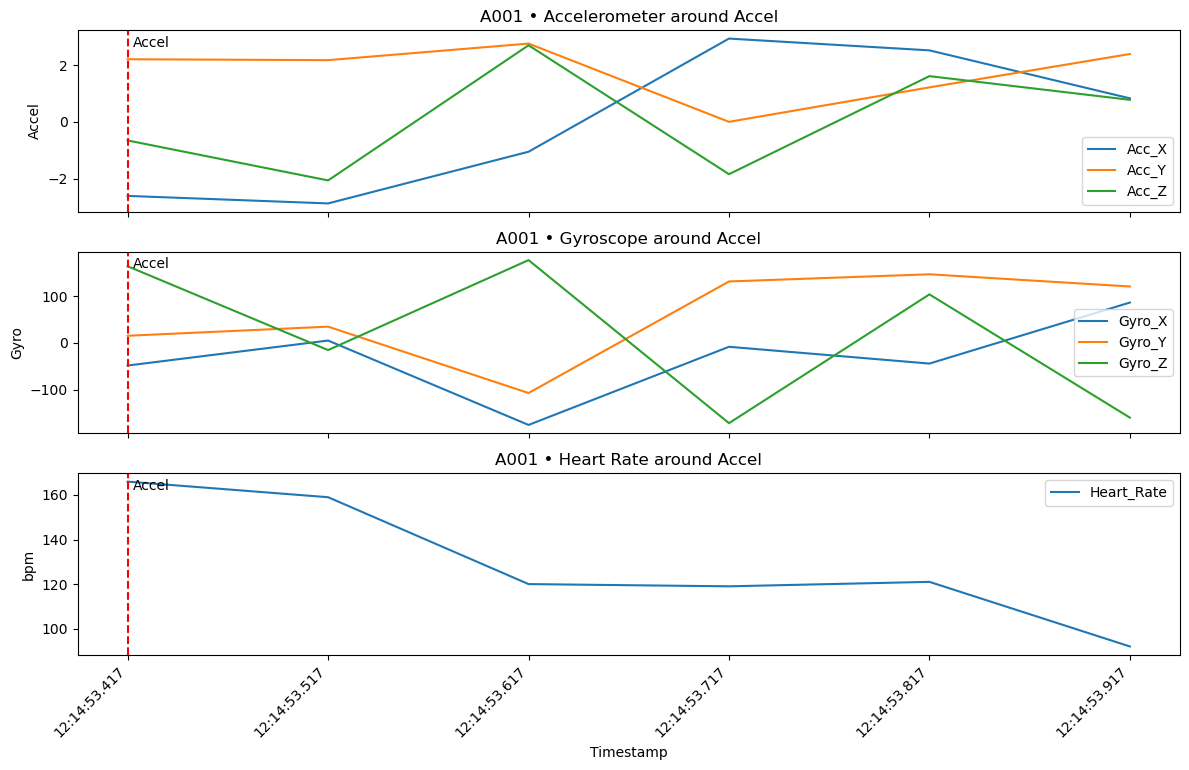

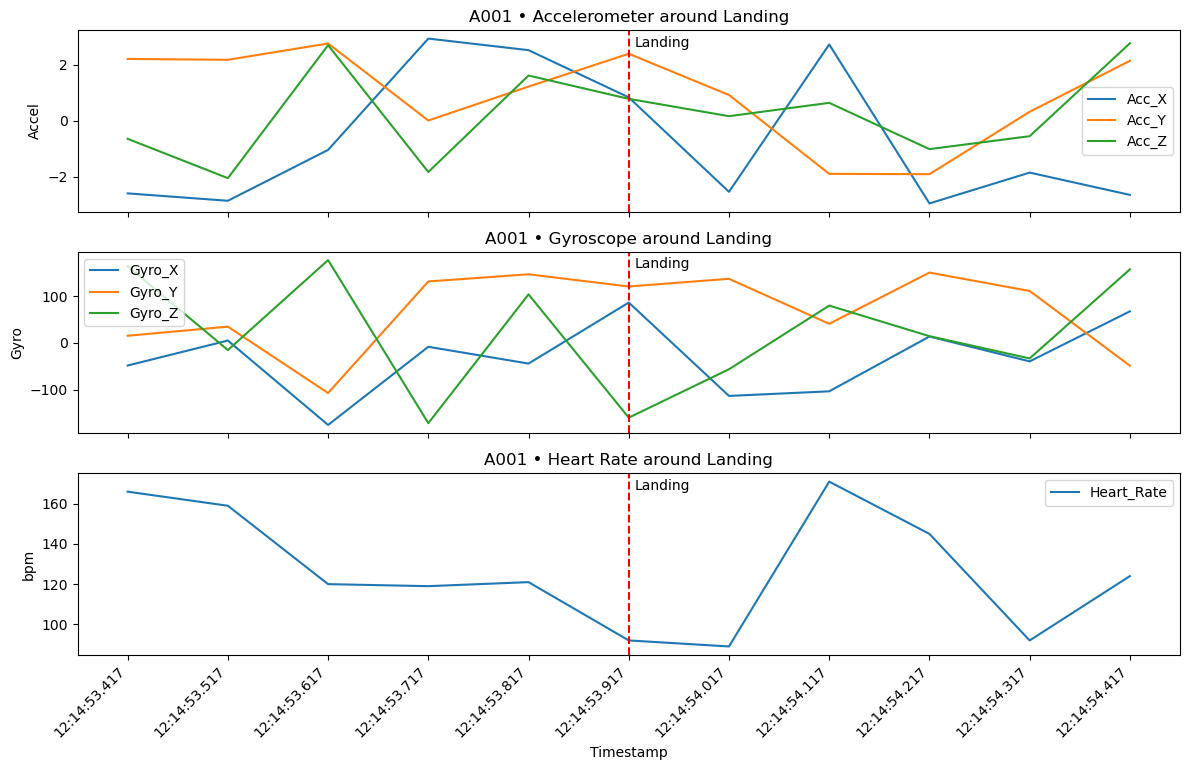

In [5]:
# Plot one example for each

events = ["Start_Run", "Stop", "Jump_Takeoff","Sprint_Mid","Accel","Landing"]

for event in events:
  plot_signal_window_with_ticks(
      df, "A001", event,
      window_before_s=0.5, window_after_s=0.5,
      event_index=0, show_all_xticks=True
  )